In [1]:
import numpy as np
DTYPE = np.float64
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os
import pickle
import gzip
from tqdm import tqdm
try:
    import flory
    
except ImportError:
    print("Installing 'flory' temporarily...")
    !pip install flory --quiet
    import flory

In [2]:
def floryHuggins(phi:DTYPE, chi:np.array):
    part_1 = np.sum(phi*np.log(phi))
    part_2 = 0

    for i in range(len(phi)):
        for j in range(i+1, len(phi)):
            part_2 += chi[i][j]*phi[i]*phi[j]

    return part_1 + part_2

In [3]:
# General Function for computing mergers of compartments

def mergers(concs:np.array, vols:np.array, merged_compartments:list):
    # Find the unmerged compartment(s)
    
    expected = len(vols)*(len(vols)+1)//2
    actual = np.sum(merged_compartments)
    unmerged = expected - actual

    # print(concs)
    # print(vols)
    # print(unmerged)

    # Compute the merged volumes
    # subtract -1 from the merged_compartments idxs to maintain python idxing

    eta_merged = 0
    for compartment in merged_compartments:
        eta_merged += vols[compartment-1]
    # print(eta_merged)

    # Calculating the compositions of components in the merged compartment
    phi_1merged = (vols[merged_compartments[0]-1]*concs[0, merged_compartments[0]-1] + vols[merged_compartments[1]-1]*concs[0, merged_compartments[1]-1])/eta_merged
    phi_2merged = (vols[merged_compartments[0]-1]*concs[1, merged_compartments[0]-1] + vols[merged_compartments[1]-1]*concs[1, merged_compartments[1]-1])/eta_merged
    phi_3merged = 1 - phi_1merged - phi_2merged
    # print(phi_1merged, phi_2merged, phi_3merged)
    # print(phi_1merged + phi_2merged + phi_3merged)

    phi_in_kmerged = [phi_1merged, phi_2merged, phi_3merged]
    phi_in_kunmerged = [concs[0, unmerged-1], concs[1, unmerged-1], concs[2, unmerged-1]]
    # print(phi_in_kmerged)
    # print(phi_in_kunmerged)

    F_merged = eta_merged*floryHuggins(phi_in_kmerged, chis) + vols[unmerged-1]*floryHuggins(phi_in_kunmerged, chis)
    # print(F_merged)

    return phi_in_kunmerged, phi_in_kmerged, eta_merged, unmerged

    

In [4]:
def perturb_mergers(concs, vols, phi_in_kunmerged,phi_in_kmerged, eta_merged, unmerged, step_size:DTYPE, n_points:int):
    # phi_1merged = phi_in_kmerged[0]
    # phi_2merged = phi_in_kmerged[1]

    phi_1merged_perturbed = np.linspace(phi_in_kmerged[0] - n_points*step_size, phi_in_kmerged[0] + n_points*step_size, 2*n_points+1)
    phi_2merged_perturbed = np.linspace(phi_in_kmerged[1] - n_points*step_size, phi_in_kmerged[1] + n_points*step_size, 2*n_points+1)
    # print(phi_1merged_perturbed)
    # print(phi_2merged_perturbed)

    accepted_phi_1merged_perturbed = []
    accepted_phi_2merged_perturbed = []
    accepted_Fs_merged = []
    
    ctr = 0
    
    for phi_1m in phi_1merged_perturbed:
        for phi_2m in phi_2merged_perturbed:
            if phi_1m<0 or phi_2m<0 or phi_1m>1 or phi_2m>1:
                continue
            
            phi_3m = 1 - phi_1m - phi_2m
            if phi_3m<0 or phi_3m>1:
                continue
            
            # Concentrations in the unmerged compartment
            phi_1unmerged = (phi_global[0] - phi_1m*(eta_merged))/(vols[unmerged-1])
            phi_2unmerged = (phi_global[1] - phi_2m*(eta_merged))/(vols[unmerged-1])

            if phi_1unmerged<0 or phi_1unmerged>1 or phi_2unmerged<0 or phi_2unmerged>1:
                continue

            phi_3unmerged = 1 - phi_1unmerged - phi_2unmerged
            if phi_3unmerged<0 or phi_3unmerged>1:
                continue
            ctr+=1

            phi_in_kmerged = [phi_1m, phi_2m, phi_3m]
            phi_in_kunmerged =  [phi_1unmerged, phi_2unmerged, phi_3unmerged]
            
            F = 0
            F = eta_merged*floryHuggins(phi_in_kmerged, chis) + vols[unmerged-1]*floryHuggins(phi_in_kunmerged, chis)

            accepted_phi_1merged_perturbed.append(phi_1m)
            accepted_phi_2merged_perturbed.append(phi_2m)
            accepted_Fs_merged.append(F)
    
    # print(ctr/len(phi_1merged_perturbed)**2)

    df = pd.DataFrame()
    df["phi_1mod"] = accepted_phi_1merged_perturbed
    df["phi_2mod"] = accepted_phi_2merged_perturbed
    df["F"] = accepted_Fs_merged
    
    return df


In [5]:
# For phi grid
step_size = 0.001
n_points = 1000

# For interaction matrix
# X is the perturbation
delX = 1
X = 0
target = 10

max_iterations = int(target / delX)

In [6]:
Xs = []
ds = []

# Global value of phis
phi_global = np.array([0.2, 0.3, 0.5], dtype = DTYPE)

with tqdm(total=max_iterations, desc="Progress") as pbar:

    while X !=10:
        # Interaction matrix
        chis = np.array([[0, 3.0, 3+X], [3.0, 0.0, 3.0], [3+X, 3.0, 0.0]], dtype = DTYPE)
        # print(chis)
        
        # Equilibrium 3 phase solution
        phases = flory.find_coexisting_phases(3, chis, phi_global, progress=False)
        
        # print("\n" + f"Equlibrium phase volumes: {phases.volumes}")
        # print("Equlibrium phase concentrations:\n" + f"{phases.fractions}")
        
        # Take the transpose as the notation is different:
        # For me: phi_ij = component i in compartment j
        # For flory: phi_ji = component i in compartment j (OR I THINK SO!)
        
        vols = phases.volumes
        
        phases.fractions = np.transpose(phases.fractions)
        concs = phases.fractions
    
        # Compute the system's phase separated Free Energy'
        # Free energy of the 3 phase system
        
        F_flory = 0
        for i in range(len(phases.volumes)):
            F_flory += phases.volumes[i]*floryHuggins(phases.fractions[:, i], chis)
        
        # print(F_flory)
        
        output_filepath = f"data/phi_g{phi_global}/X{X}/"
        output_filename = f"system_definition_and_flory_output.pkl"
        if not os.path.exists(output_filepath):
            os.makedirs(output_filepath)
        output_file = os.path.join(output_filepath, output_filename)
        
        with gzip.open(output_file, "wb") as f:
            pickle.dump({
                'chis': chis,
                'phi_global': phi_global,
                'phase_fractions': phases.fractions.T,
                'phase_volumes': phases.volumes,
                'flory_free_energy': F_flory
            }, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    
        merged_compartments_list = [[1, 2], [2, 3], [1, 3]]
        # merged_compartments_list = [[1, 2]]
        
        min_phi_1mergedguess_global, min_phi_2mergedguess_global = 0, 0
        min_phi_1merged_global, min_phi_2merged_global = 0, 0
        min_Fmerged_global = DTYPE(np.inf)
        min_merged_compartment_idxs = None # Stores the compartment with the minimum free energy
        min_df = None # stores the df for the merged compartments with the minimum free energy
        
        for merged_compartments in merged_compartments_list:
            # print(merged_compartments)
            
            phi_in_kunmerged, phi_in_kmerged, eta_merged, unmerged = mergers(concs, vols, merged_compartments)
            
            df = perturb_mergers(concs, vols, phi_in_kunmerged,phi_in_kmerged, eta_merged, unmerged, step_size, n_points)
        
        
            # Capture the compartment with the minimum Free Energy
            
            min_F_index = np.argmin(df["F"])
            min_phi1 = df["phi_1mod"].iloc[min_F_index]
            min_phi2 = df["phi_2mod"].iloc[min_F_index]
            min_F = df["F"].iloc[min_F_index]
        
            if min_F < min_Fmerged_global:
        
                min_phi_1mergedguess_global = phi_in_kmerged[0] 
                min_phi_2mergedguess_global = phi_in_kmerged[1]
                
                min_Fmerged_global = min_F
                min_phi_1merged_global = min_phi1
                min_phi_2merged_global = min_phi2
                
                min_merged_compartment_idxs = merged_compartments
                min_df = df
    
        c1 = min_phi_1mergedguess_global - min_phi_1merged_global
        c2 = min_phi_2mergedguess_global - min_phi_2merged_global
        c3 = (1-min_phi_1mergedguess_global-min_phi_2mergedguess_global) - (1-min_phi_1merged_global-min_phi_2merged_global)
        
        d = np.sqrt(c1**2 + c2**2 + c3**2)
        
        output_filepath = f"data/phi_g{phi_global}/X{X}/"
        output_filename = f"merged_best.pkl"
        if not os.path.exists(output_filepath):
            os.makedirs(output_filepath)
        output_file = os.path.join(output_filepath, output_filename)
        
        with gzip.open(output_file, "wb") as f:
            pickle.dump({
                'best_merger': min_merged_compartment_idxs,
                'merger_initial_guess': [min_phi_1mergedguess_global, min_phi_2mergedguess_global], # stores phi_1merged and phi_2merged
                'merged_best': [min_phi_1merged_global, min_phi_2merged_global],
                'distance_guess_best': d,
                'merger_free_energy_min': min_Fmerged_global,
                "_metadata": {"best_merger-> merging compartments which give the best result",
                              "merger_initial_guess-> initial weighted averages phi_1,merged and phi_2,merged",
                              "merged_best-> best phi_1,merged and phi_2,merged after finding the minimum of the free energy",
                              "distance_guess_best-> distance between the initial guess and the best component concentration values",
                              "merger_free_energy_min-> free energy computed at the best component concentration values"
                             }
            }, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    
        phi1_grid = np.linspace(min(min_df["phi_1mod"]), max(min_df["phi_1mod"]), 100)
        phi2_grid = np.linspace(min(min_df["phi_2mod"]), max(min_df["phi_2mod"]), 100)
        phi1_mesh, phi2_mesh = np.meshgrid(phi1_grid, phi2_grid)
        
        
        # Interpolate F values onto the grid
        F_grid = griddata(
            (min_df["phi_1mod"], min_df["phi_2mod"]), 
            min_df["F"], 
            (phi1_mesh, phi2_mesh), 
            method='cubic'
        )
        
        # Create the contour plot
        fig, ax = plt.subplots(figsize=(8, 6))
        contour = plt.contourf(phi1_mesh, phi2_mesh, F_grid, levels=1000, cmap = "RdYlBu_r")
        plt.colorbar(contour, label=r'$F\, (k_BT)$')
        
        
        # Mark the original point
        label = r"($\phi_{1, \text{merged}}^{in}, \phi_{2, \text{merged}}^{in}) =$" + f"({min_phi_1mergedguess_global:.3f}, {min_phi_2mergedguess_global:.3f})"
        ax.scatter(
            min_phi_1mergedguess_global, min_phi_2mergedguess_global, 
            color='magenta',
            marker = ".",
            s=50, 
            label=label
        )
        
        # Find the minimum free energy point
        min_F_index = np.argmin(min_df["F"])
        min_phi1 = min_df["phi_1mod"].iloc[min_F_index]
        min_phi2 = min_df["phi_2mod"].iloc[min_F_index]
        min_F = min_df["F"].iloc[min_F_index]
        
        label = r"($\phi_{1, \text{merged}}^{\text{best}}, \phi_{2, \text{merged}}^{\text{best}}) =$" + f"({min_phi1:.3f}, {min_phi2:.3f})"
        
        ax.scatter(
            min_phi1, min_phi2, 
            color='lightgreen', 
            s=100, 
            marker='*',
            edgecolor='black',
            linewidth=0.5,
            label=label
        )
        
        # Add contour lines
        CS = plt.contour(phi1_mesh, phi2_mesh, F_grid, levels=40, colors='k', linewidths=0.25)
        # ax.clabel(CS, inline=True, fontsize=8)
        
        ax.set_xlabel(r'$\phi_{1, \text{merged}}$', fontsize=12)
        ax.set_ylabel(r'$\phi_{2, \text{merged}}$', fontsize=12)
        title = f"X = {X:.1f}" + "\n" + r"$\Phi^{\text{global}}=$" + f"{phi_global}" +"\n" + f'Merged compartments: {min_merged_compartment_idxs[0]} + {min_merged_compartment_idxs[1]}' + "\n" + r"$F_{\text{min}}=$" + f"{min_F:.3f}" 
        plt.title(title, fontsize=14)
        plt.legend(loc = "best")
        plt.tight_layout()
        phi1_grid = np.linspace(min(min_df["phi_1mod"]), max(min_df["phi_1mod"]), 100)
        phi2_grid = np.linspace(min(min_df["phi_2mod"]), max(min_df["phi_2mod"]), 100)
        phi1_mesh, phi2_mesh = np.meshgrid(phi1_grid, phi2_grid)
        
        output_filepath = f"data/phi_g{phi_global}/X{X}/"
        output_filename = f"merged_best.png"
        if not os.path.exists(output_filepath):
            os.makedirs(output_filepath)
        output_file = os.path.join(output_filepath, output_filename)
        
        plt.savefig(output_file, dpi =400)
        plt.close()
    
    
        Xs.append(X)
        ds.append(d)
        
        X += delX
        pbar.update(1)

Progress: 100%|█████████████████████████████████| 10/10 [01:48<00:00, 10.82s/it]


In [7]:
output_filepath = f"data/phi_g{phi_global}/"
output_filename = f"X_vs_d.pkl"
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)
output_file = os.path.join(output_filepath, output_filename)

with gzip.open(output_file, "wb") as f:
    pickle.dump({
        "Xs": Xs,
        "ds": ds
    }, f, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
with gzip.open(output_file, 'rb') as f:
    loaded_data = pickle.load(f)

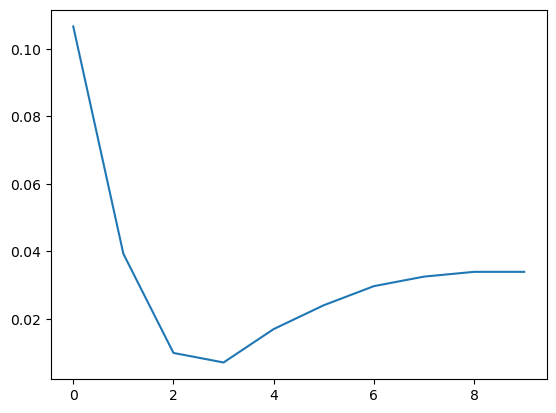

In [9]:
plt.plot(loaded_data["Xs"], loaded_data["ds"])